<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/PCautoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Autoencoder Imputation + LSTM Survival Prediction Pipeline
Loading data...

STAGE 1: Autoencoder-based Imputation
Starting advanced preprocessing with autoencoder imputation...
Removed 65 rows with missing VISDAY
Data after handling missing survival outcomes: 8056 rows
Selected 34 features for modeling
=== MISSING DATA ANALYSIS ===
Missing data by column:
                         missing_count  missing_percentage
cycle_number                      1969           24.441410
total_body_systems                1019           12.648957
max_ae_duration                   1019           12.648957
most_recent_ae_severity           1019           12.648957
mean_ae_duration                  1019           12.648957
total_cycles                         9            0.111718


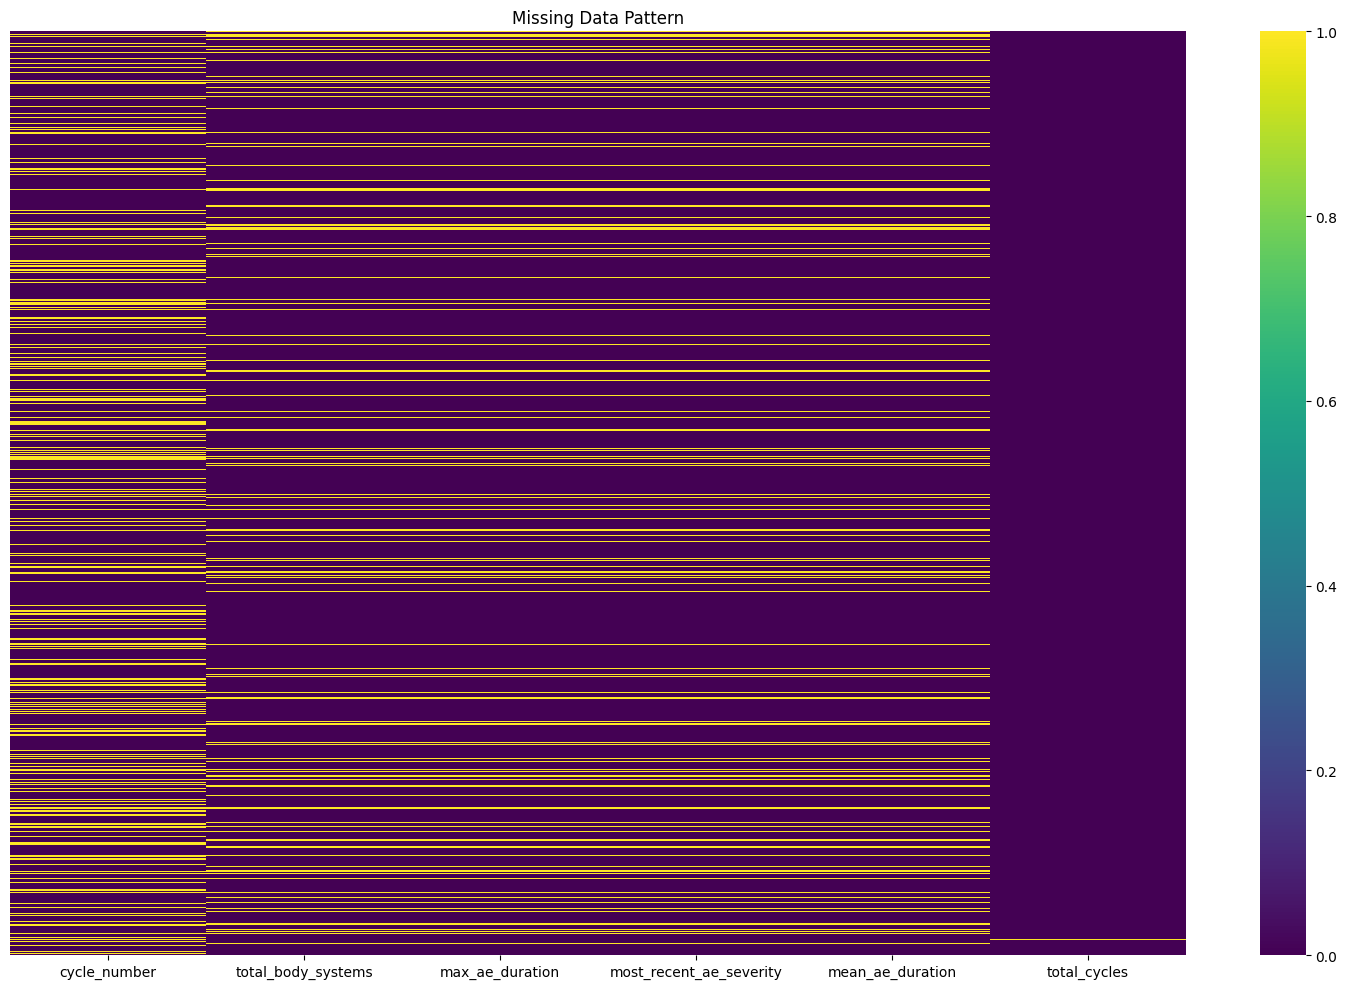

Numeric columns: 11
Categorical columns: 23

Preparing 34 features for autoencoder imputation:
- Numeric features: 11
- Categorical features: 23
Final feature matrix shape: (8056, 68)
Missing mask shape: (8056, 68)

Data split:
  Training: (4511, 68)
  Validation: (1128, 68)
  Test: (2417, 68)

Training Denoising Autoencoder for imputation...
Denoising Autoencoder architecture:


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_7                │ (None, 68)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 128)            │         8,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 68)             │         8,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,908 (155.89 KB)

 Trainable params: 39,140 (152.89 KB)

 Non-trainable params: 768 (3.00 KB)

None
Training denoising autoencoder with missing-aware loss...
Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.4733 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4258 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2218 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1752 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1559 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1452 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1324 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1224 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/100
71/71 ━━━━━━━━━━━━━

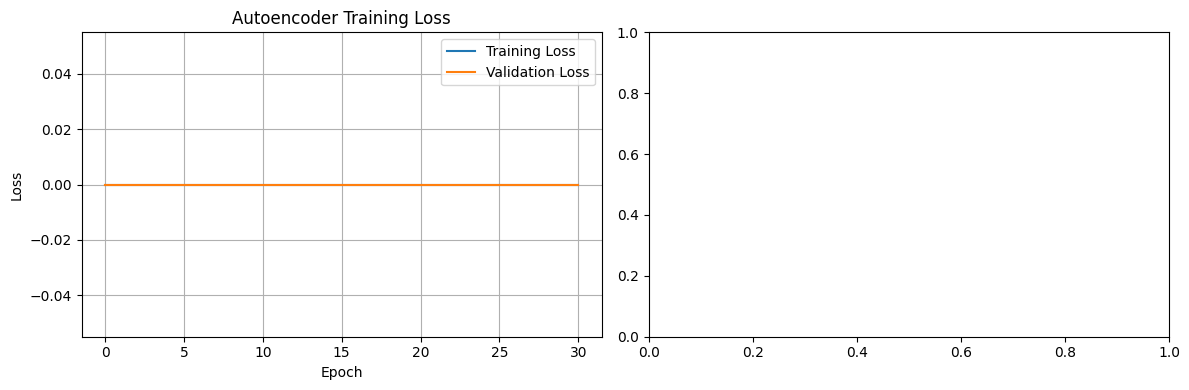


Imputing missing values...
Imputing missing values using trained autoencoder...
Imputed 3382.0 missing values
Imputing missing values using trained autoencoder...
Imputed 857.0 missing values
Imputing missing values using trained autoencoder...
Imputed 1815.0 missing values

STAGE 2: LSTM Survival Prediction

Sequence shapes:
  Training sequences: (1503, 3, 68), labels: (1503, 2)
  Validation sequences: (376, 3, 68), labels: (376, 2)
  Test sequences: (805, 3, 68), labels: (805, 2)

Training LSTM Autoencoder for feature extraction...
LSTM Autoencoder architecture:


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 3, 68)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 3, 64)          │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 3, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 68)          │         4,420 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,036 (328.27 KB)

 Trainable params: 84,036 (328.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Training LSTM autoencoder...
Epoch 1/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 2.3959 - mae: 0.4639 - val_loss: 1.7386 - val_mae: 0.4216 - learning_rate: 0.0010
Epoch 2/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6057 - mae: 0.4120 - val_loss: 1.4702 - val_mae: 0.3938 - learning_rate: 0.0010
Epoch 3/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4347 - mae: 0.3920 - val_loss: 1.4147 - val_mae: 0.3898 - learning_rate: 0.0010
Epoch 4/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3844 - mae: 0.3880 - val_loss: 1.3703 - val_mae: 0.3851 - learning_rate: 0.0010
Epoch 5/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3373 - mae: 0.3836 - val_loss: 1.2937 - val_mae: 0.3802 - learning_rate: 0.0010
Epoch 6/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2598 - mae: 0.3784 - val_loss: 1.2120 - val_mae: 0.3725 - learning_rate: 0.0010
Epoch 7/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1876 - mae: 0.3705 - val_loss: 1.1460 - val_mae: 0.3622 - learnin

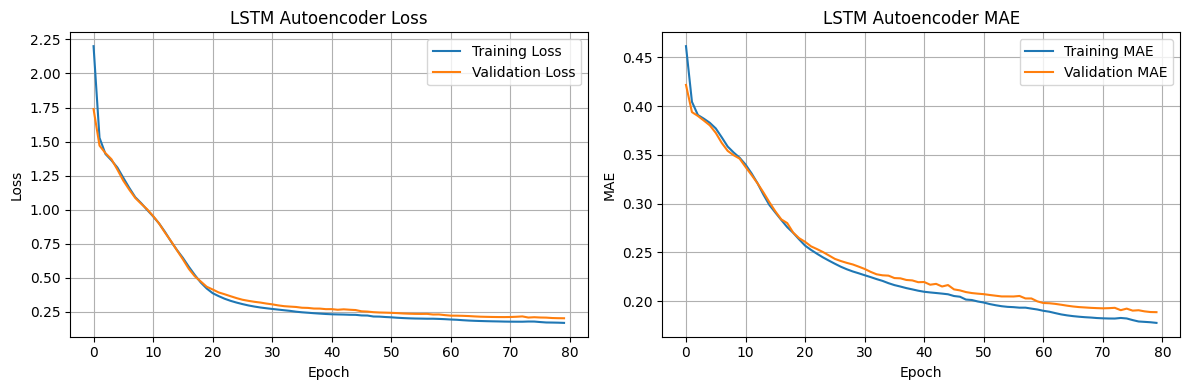


Extracting encoded features...

Training Survival LSTM...
Survival LSTM architecture:


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1, 32)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 1, 128)    │     49,664 │ input_layer_18[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 1, 128)    │          0 │ bidirectional_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 1, 1)      │        129 │ dropout_14[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_7 (Softmax) │ (None, 1, 1)      │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 1, 128)    │          0 │ dropout_14[0][0], │
│ (Multiply)          │                   │            │ softmax_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 128)       │          0 │ multiply_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 64)        │      8,256 │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_73[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 32)        │      2,080 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_74[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ survival_time       │ (None, 1)         │         33 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ event (Dense)       │ (None, 1)         │         33 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,579 (236.64 KB)

 Trainable params: 60,387 (235.89 KB)

 Non-trainable params: 192 (768.00 B)

None
Training Survival LSTM...
Epoch 1/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - event_accuracy: 0.4957 - event_auc_7: 0.4564 - event_loss: 0.9010 - loss: 18687.8555 - survival_time_loss: 31146.4043 - survival_time_mae: 133.1516 - survival_time_root_mean_squared_error: 176.2951 - val_event_accuracy: 0.8617 - val_event_auc_7: 0.4758 - val_event_loss: 0.6404 - val_loss: 20005.5957 - val_survival_time_loss: 33687.0117 - val_survival_time_mae: 134.0373 - val_survival_time_root_mean_squared_error: 182.5986 - learning_rate: 5.0000e-04
Epoch 2/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - event_accuracy: 0.5350 - event_auc_7: 0.4840 - event_loss: 0.7968 - loss: 18412.9531 - survival_time_loss: 30688.3008 - survival_time_mae: 131.8811 - survival_time_root_mean_squared_error: 174.9937 - val_event_accuracy: 0.8617 - val_event_auc_7: 0.5304 - val_event_loss: 0.6014 - val_loss: 19884.1523 - val_survival_time_loss: 33485.3516 - val_survival_time_mae: 133.4519 - val_survival_time_root_mean_square

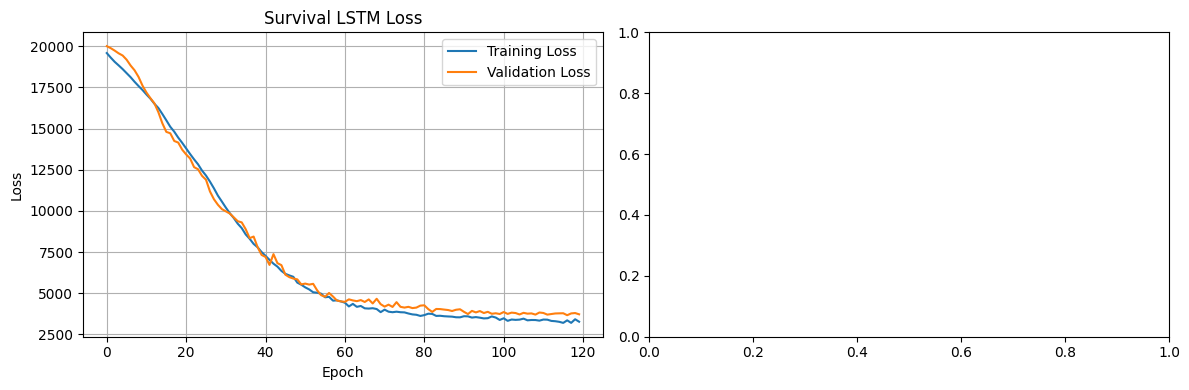


MODEL EVALUATION
Evaluating model...

Evaluation Results:
loss: 3970.5015
compile_metrics: 6728.6450
survival_time_loss: 0.4111
event_loss: 0.8646

Detailed Performance Metrics:

Survival Time Prediction:
  MSE: 6617.2347
  MAE: 54.4095
  RMSE: 81.3464

Event Prediction:
  Accuracy: 0.8646
  AUC-ROC: 0.5430


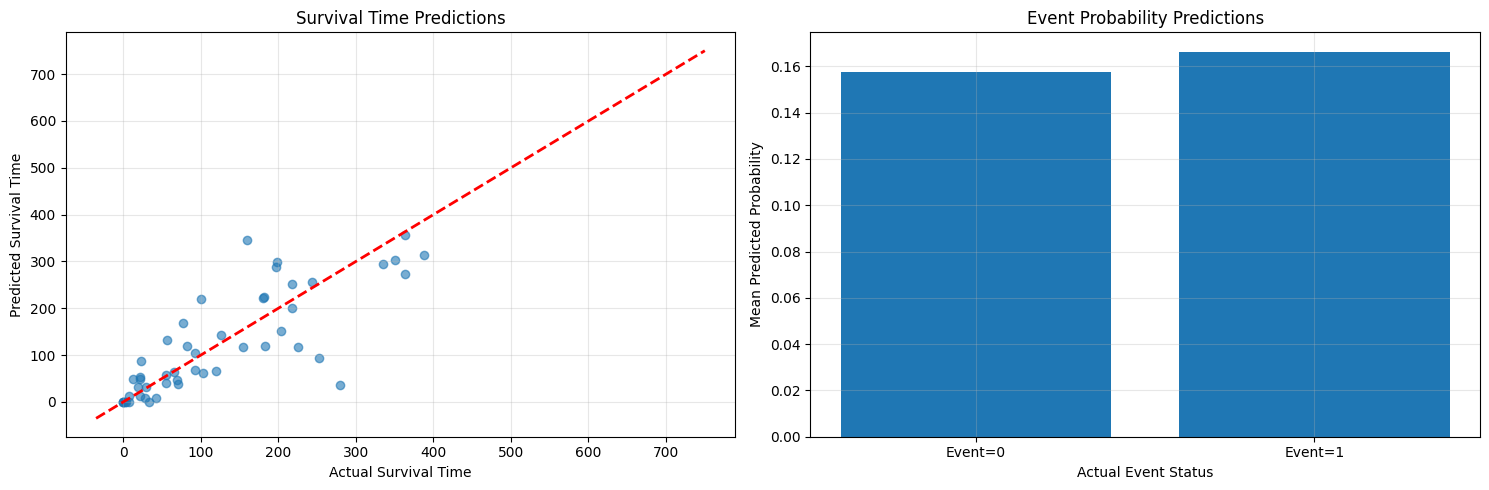


PIPELINE COMPLETED SUCCESSFULLY!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

class AdvancedMissingDataHandler:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_stats = {}
        self.missing_mask = None
        self.numeric_cols = None
        self.categorical_cols = None

    def analyze_data_types(self, df):
        """Analyze data types and identify numeric vs categorical columns"""
        numeric_cols = []
        categorical_cols = []

        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                # Check if it's actually categorical (limited unique values)
                unique_ratio = df[col].nunique() / len(df[col])
                if unique_ratio < 0.05 and df[col].nunique() < 20:
                    categorical_cols.append(col)
                else:
                    numeric_cols.append(col)
            else:
                categorical_cols.append(col)

        print(f"Numeric columns: {len(numeric_cols)}")
        print(f"Categorical columns: {len(categorical_cols)}")

        return numeric_cols, categorical_cols

    def encode_categorical(self, df, categorical_cols):
        """Encode categorical variables"""
        df_encoded = df.copy()

        for col in categorical_cols:
            if col in df.columns:
                # Fill missing categorical values with a special value
                df_encoded[col] = df[col].fillna('MISSING_CAT')

                # Explicitly convert to string to prevent TypeError with mixed types
                df_encoded[col] = df_encoded[col].astype(str)

                # Create or use existing label encoder
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    self.label_encoders[col].fit(df_encoded[col])

                # Transform the column
                df_encoded[col] = self.label_encoders[col].transform(df_encoded[col])

        return df_encoded

    def create_missing_mask(self, df):
        """Create mask indicating missing values"""
        return df.isnull().astype(int).values

    def create_input_with_missing_indicators(self, df, numeric_cols, categorical_cols):
        """Create input with missing indicators and placeholder values"""
        df_processed = df.copy()

        # Store statistics for numeric columns
        for col in numeric_cols:
            if col in df.columns:
                self.feature_stats[col] = {
                    'mean': df[col].mean(),
                    'median': df[col].median(),
                    'std': df[col].std(),
                    'min': df[col].min(),
                    'max': df[col].max()
                }

        # Process numeric columns
        for col in numeric_cols:
            if col in df.columns:
                # Convert infinite values to NaN before filling with placeholder
                df_processed[col] = df_processed[col].replace([np.inf, -np.inf], np.nan)

                # Create missing indicator
                indicator_name = f"{col}_missing"
                df_processed[indicator_name] = df[col].isnull().astype(int)

                # Fill with placeholder (scaled zero)
                placeholder = 0  # Will be scaled later
                df_processed[col] = df_processed[col].fillna(placeholder)

        # Process categorical columns
        df_processed = self.encode_categorical(df_processed, categorical_cols)

        # Create missing indicators for categorical columns
        for col in categorical_cols:
            if col in df.columns:
                # Create missing indicator (after encoding)
                indicator_name = f"{col}_missing"
                df_processed[indicator_name] = (df[col].isnull()).astype(int)

        return df_processed

    def prepare_for_autoencoder(self, df, feature_cols):
        """Prepare data for autoencoder imputation"""
        # Identify numeric and categorical columns
        self.numeric_cols, self.categorical_cols = self.analyze_data_types(df[feature_cols])

        print(f"\nPreparing {len(feature_cols)} features for autoencoder imputation:")
        print(f"- Numeric features: {len(self.numeric_cols)}")
        print(f"- Categorical features: {len(self.categorical_cols)}")

        # Create input with missing indicators
        df_processed = self.create_input_with_missing_indicators(
            df, self.numeric_cols, self.categorical_cols
        )

        # Get all columns including missing indicators
        all_columns = list(feature_cols)
        for col in feature_cols:
            if col in df_processed.columns and f"{col}_missing" not in all_columns:
                all_columns.append(f"{col}_missing")

        # Ensure all_columns has only unique values and correct order (optional, but good practice)
        # It's important that all_columns here matches the order of columns in X
        # For simplicity, we'll rely on df_processed column order for X and align mask to it
        # Let's ensure df_processed has all_columns in the right order for X creation
        # The next line was already implicitly sorting them, let's make it explicit
        all_columns = [col for col in df_processed.columns if col in set(all_columns)]

        # Scale numeric features (including those with placeholders)
        numeric_features_to_scale = [col for col in self.numeric_cols if col in df_processed.columns]
        if numeric_features_to_scale:
            df_processed[numeric_features_to_scale] = self.scaler.fit_transform(
                df_processed[numeric_features_to_scale]
            )

        # Create final feature matrix
        X = df_processed[all_columns].values

        # --- Start of modifications for the missing mask ---
        # Create a new DataFrame for the missing mask, initialized with zeros
        full_missing_mask_df = pd.DataFrame(0, index=df_processed.index, columns=all_columns, dtype=np.float32)

        # Populate the mask for original features
        for original_col in feature_cols:
            if original_col in full_missing_mask_df.columns:
                full_missing_mask_df[original_col] = df[original_col].isnull().astype(np.float32)

        # Assign the values of the full_missing_mask_df to self.missing_mask
        self.missing_mask = full_missing_mask_df.values
        # --- End of modifications ---

        print(f"Final feature matrix shape: {X.shape}")
        print(f"Missing mask shape: {self.missing_mask.shape}")

        return X, all_columns


class DenoisingAutoencoderImputer:
    def __init__(self, input_dim, encoding_dim=32, noise_factor=0.1):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.noise_factor = noise_factor
        self.autoencoder = None
        self.history = None

    def build_autoencoder(self):
        """Build a denoising autoencoder for imputation"""
        # Input layer
        input_layer = layers.Input(shape=(self.input_dim,))

        # Add noise for denoising (during training only)
        noisy_input = layers.GaussianNoise(self.noise_factor)(input_layer)

        # Encoder
        encoded = layers.Dense(128, activation='relu')(noisy_input)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dense(self.input_dim, activation='linear')(decoded)

        # Create model
        self.autoencoder = models.Model(inputs=input_layer, outputs=decoded)

        # Compile with custom loss
        self.autoencoder.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        print("Denoising Autoencoder architecture:")
        print(self.autoencoder.summary())

        return self.autoencoder

    def custom_loss(self, y_true, y_pred, missing_mask):
        """Custom loss that only considers non-missing values"""
        # Calculate squared error
        squared_error = tf.square(y_true - y_pred)

        # Mask out missing values (where mask == 1)
        valid_mask = tf.cast(tf.equal(missing_mask, 0), tf.float32)

        # Apply mask
        masked_error = squared_error * valid_mask

        # Calculate mean over non-missing values
        loss = tf.reduce_sum(masked_error) / (tf.reduce_sum(valid_mask) + 1e-8)

        return loss

    def train_with_missing_awareness(self, X_train, missing_mask_train, X_val, missing_mask_val,
                                     epochs=150, batch_size=64):
        """Train autoencoder with missing-aware loss"""

        # Create a custom training loop to handle missing values
        class MissingAwareModel(keras.Model):
            def train_step(self, data):
                # Unpack data: `data` yields `(x_features_batch, (y_true_batch, missing_mask_batch))`
                x_features, (y_true, missing_mask) = data

                with tf.GradientTape() as tape:
                    # Forward pass: model predicts based on x_features
                    y_pred = self(x_features, training=True)

                    # Custom loss only on observed values (using y_true and missing_mask)
                    valid_mask = tf.cast(tf.equal(missing_mask, 0), tf.float32)
                    loss = tf.reduce_sum(tf.square(y_true - y_pred) * valid_mask) / (tf.reduce_sum(valid_mask) + 1e-8)

                # Compute gradients
                trainable_vars = self.trainable_variables
                gradients = tape.gradient(loss, trainable_vars)

                # Update weights
                self.optimizer.apply_gradients(zip(gradients, trainable_vars))

                return {"loss": loss}

            def test_step(self, data):
                # Unpack data for validation: `data` yields `(x_features_batch, (y_true_batch, missing_mask_batch))`
                x_features, (y_true, missing_mask) = data

                # Forward pass
                y_pred = self(x_features, training=False)

                # Custom loss only on observed values
                valid_mask = tf.cast(tf.equal(missing_mask, 0), tf.float32)
                loss = tf.reduce_sum(tf.square(y_true - y_pred) * valid_mask) / (tf.reduce_sum(valid_mask) + 1e-8)

                # Here, we will just return the custom loss to monitor 'val_loss'
                return {"loss": loss}

        # Create model wrapper
        model_wrapper = MissingAwareModel(inputs=self.autoencoder.input,
                                         outputs=self.autoencoder.output)
        # Compile with a dummy loss, as the actual loss calculation is handled in train_step and test_step
        # This satisfies Keras's requirement for a loss argument.
        model_wrapper.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())

        # Prepare training data: x is X_train, y is (X_train, missing_mask_train)
        train_data = tf.data.Dataset.from_tensor_slices(
            (X_train, (X_train, missing_mask_train))
        ).batch(batch_size).shuffle(1000)

        val_data = tf.data.Dataset.from_tensor_slices(
            (X_val, (X_val, missing_mask_val))
        ).batch(batch_size)

        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=15,
            min_lr=1e-6,
            verbose=1
        )

        print("Training denoising autoencoder with missing-aware loss...")

        # Train model
        history = model_wrapper.fit(
            train_data,
            validation_data=val_data,
            epochs=epochs,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        self.history = history
        self.model_wrapper = model_wrapper

        # Plot training history
        self.plot_training_history()

        return history

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            return

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss
        axes[0].plot(self.history.history['loss'], label='Training Loss')
        if 'val_loss' in self.history.history:
            axes[0].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0].set_title('Autoencoder Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        plt.tight_layout()
        plt.show()

    def impute_missing_values(self, X, missing_mask):
        """Impute missing values using trained autoencoder"""
        print("Imputing missing values using trained autoencoder...")

        # Get predictions
        X_imputed = self.autoencoder.predict(X, verbose=0)

        # Convert X to a NumPy array to use the .copy() method and array-like indexing
        X_np = X.numpy() if isinstance(X, tf.Tensor) else X

        # Only replace missing values (where missing_mask == 1)
        X_final = X_np.copy()
        X_final[missing_mask == 1] = X_imputed[missing_mask == 1]

        # Calculate imputation statistics
        n_imputed = np.sum(missing_mask)
        print(f"Imputed {n_imputed} missing values")

        return X_final


class SurvivalDataPreprocessor:
    def __init__(self):
        self.feature_stats = {}
        self.selected_features = []
        self.missing_handler = AdvancedMissingDataHandler()
        self.autoencoder_imputer = None

    def analyze_missing_data(self, df):
        """Comprehensive analysis of missing data patterns"""
        print("=== MISSING DATA ANALYSIS ===")

        total_rows = len(df)
        missing_summary = pd.DataFrame({
            'missing_count': df.isnull().sum(),
            'missing_percentage': (df.isnull().sum() / total_rows) * 100
        }).sort_values('missing_percentage', ascending=False)

        print("Missing data by column:")
        print(missing_summary[missing_summary['missing_count'] > 0])

        plt.figure(figsize=(15, 10))
        missing_cols = missing_summary[missing_summary['missing_count'] > 0].index
        if len(missing_cols) > 0:
            sns.heatmap(df[missing_cols].isnull(), cbar=True, yticklabels=False, cmap='viridis')
            plt.title('Missing Data Pattern')
            plt.tight_layout()
            plt.show()

        return missing_summary

    def handle_missing_survival_data(self, df):
        """Handle missing values in survival outcomes"""
        df_clean = df.copy()

        survival_vars = ['VISDAY', 'os_event']
        for var in survival_vars:
            if var in df.columns:
                missing_count = df[var].isnull().sum()
                if missing_count > 0:
                    print(f"WARNING: {missing_count} missing values in {var}")
                    df_clean = df_clean.dropna(subset=[var])
                    print(f"Removed {missing_count} rows with missing {var}")

        return df_clean

    def select_features(self, df, max_missing_percentage=50):
        """Select features for analysis"""
        candidate_features = [
            'AGE', 'VISDAY', 'cycle_number', 'total_cycles',
            'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count',
            'grade3_plus_count', 'any_grade3_plus', 'total_body_systems',
            'treatment_related_count', 'any_treatment_related', 'grade1_count',
            'grade2_count', 'grade3_count', 'grade4_count', 'drug_interrupted',
            'drug_reduced', 'drug_withdrawn', "drug_not_changed", "other_drug_interrupted",
            "other_drug_reduced", "other_drug_withdrawn", "concomitant_treatment_given",
            'cum_any_grade3_plus', 'cum_any_treatment_related', "cum_drug_withdrawn",
            "cum_other_drug_withdrawn", "cum_concomitant_treatment", "ongoing_ae_count",
            "mean_ae_duration", "max_ae_duration", "most_recent_ae_term", "most_recent_ae_severity"
        ]

        # Filter to available columns
        available_features = [col for col in candidate_features if col in df.columns]

        # Remove features with text/categorical data that can't be imputed easily
        text_features = ['most_recent_ae_term']
        features_to_keep = [f for f in available_features if f not in text_features]

        print(f"Selected {len(features_to_keep)} features for modeling")

        self.selected_features = features_to_keep
        return features_to_keep

    def preprocess_for_autoencoder_imputation(self, df):
        """Complete preprocessing pipeline with autoencoder imputation"""
        print("Starting advanced preprocessing with autoencoder imputation...")

        # Step 1: Handle survival data
        df_clean = self.handle_missing_survival_data(df)
        print(f"Data after handling missing survival outcomes: {len(df_clean)} rows")

        # Step 2: Select features
        features = self.select_features(df_clean)

        # Step 3: Analyze missing patterns
        missing_summary = self.analyze_missing_data(df_clean[features])

        # Step 4: Prepare for autoencoder imputation
        X_prepared, all_columns = self.missing_handler.prepare_for_autoencoder(
            df_clean, features
        )

        # Step 5: Get missing mask
        missing_mask = self.missing_handler.missing_mask

        # Step 6: Add survival variables back
        survival_data = df_clean[['VISDAY', 'os_event']].values

        return X_prepared, missing_mask, survival_data, all_columns, features


class AutoencoderLSTM_Survival:
    def __init__(self, input_dim, encoding_dim=32, sequence_length=3, lstm_units=64):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.autoencoder = None
        self.encoder = None
        self.lstm_model = None
        self.history_autoencoder = None
        self.history_lstm = None

    def build_lstm_autoencoder(self):
        """Build LSTM-based autoencoder for time series imputation"""
        # Input layer
        input_layer = layers.Input(shape=(self.sequence_length, self.input_dim))

        # Encoder LSTM
        encoded = layers.LSTM(self.encoding_dim * 2, return_sequences=True)(input_layer)
        encoded = layers.LSTM(self.encoding_dim, return_sequences=False)(encoded)

        # Repeat vector for decoder
        repeated = layers.RepeatVector(self.sequence_length)(encoded)

        # Decoder LSTM
        decoded = layers.LSTM(self.encoding_dim, return_sequences=True)(repeated)
        decoded = layers.LSTM(self.encoding_dim * 2, return_sequences=True)(decoded)
        decoded = layers.TimeDistributed(layers.Dense(self.input_dim))(decoded)

        # Create autoencoder
        self.autoencoder = models.Model(inputs=input_layer, outputs=decoded)

        # Create encoder
        self.encoder = models.Model(inputs=input_layer, outputs=encoded)

        # Compile
        self.autoencoder.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        print("LSTM Autoencoder architecture:")
        print(self.autoencoder.summary())

        return self.autoencoder, self.encoder

    def build_survival_lstm(self):
        """Build LSTM model for survival prediction"""
        # Input layer: Expects (sequence_length, encoding_dim) after feature extraction
        input_layer = layers.Input(shape=(self.sequence_length, self.input_dim)) # input_dim here will be the feature_dim = encoding_dim of the AE-LSTM

        # Bidirectional LSTM layer
        lstm_sequence_output = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True))(input_layer)
        lstm_sequence_output = layers.Dropout(0.3)(lstm_sequence_output)

        # --- Refactored Attention Mechanism ---
        # Calculate attention scores
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_sequence_output)
        # Calculate attention weights
        attention_weights = layers.Softmax(axis=1)(attention_scores)
        # Apply attention weights to the LSTM output
        context_vector = layers.Multiply()([lstm_sequence_output, attention_weights])
        # Sum the context vector along the sequence dimension to get a single representation
        sent_representation = layers.Lambda(lambda xin: tf.reduce_sum(xin, axis=1))(context_vector)
        # --- End Refactored Attention Mechanism ---

        # Dense layers
        dense_out = layers.Dense(64, activation='relu')(sent_representation)
        dense_out = layers.BatchNormalization()(dense_out)
        dense_out = layers.Dropout(0.2)(dense_out)
        dense_out = layers.Dense(32, activation='relu')(dense_out)
        dense_out = layers.BatchNormalization()(dense_out)

        # Output layers
        output_survival_time = layers.Dense(1, activation='relu', name='survival_time')(dense_out)
        output_event = layers.Dense(1, activation='sigmoid', name='event')(dense_out)

        # Create model
        self.lstm_model = models.Model(
            inputs=input_layer,
            outputs=[output_survival_time, output_event]
        )

        # Compile
        self.lstm_model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss={
                'survival_time': 'mse',
                'event': 'binary_crossentropy'
            },
            loss_weights={
                'survival_time': 0.6,
                'event': 0.4
            },
            metrics={
                'survival_time': ['mae', tf.keras.metrics.RootMeanSquaredError()],
                'event': ['accuracy', tf.keras.metrics.AUC()]
            }
        )

        print("Survival LSTM architecture:")
        print(self.lstm_model.summary())

        return self.lstm_model

    def create_sequences(self, X, y, sequence_length):
        """Create sequences for LSTM"""
        sequences = []
        labels = []

        for i in range(len(X) - sequence_length + 1):
            sequences.append(X[i:i+sequence_length])
            # Use the last time point's label
            labels.append(y[i+sequence_length-1])

        return np.array(sequences), np.array(labels)

    def train_lstm_autoencoder(self, X_train_seq, X_val_seq, epochs=100, batch_size=32):
        """Train LSTM autoencoder"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=25,
            restore_best_weights=True
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )

        print("Training LSTM autoencoder...")
        self.history_autoencoder = self.autoencoder.fit(
            X_train_seq, X_train_seq,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val_seq, X_val_seq),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        self.plot_training_history(self.history_autoencoder, "LSTM Autoencoder")

        return self.history_autoencoder

    def train_survival_lstm(self, X_train_encoded_seq, y_train, X_val_encoded_seq, y_val, epochs=150, batch_size=32):
        """Train survival LSTM"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=15,
            min_lr=1e-6
        )

        # Convert y to dictionary format for multi-output model
        y_train_dict = {
            'survival_time': y_train[:, 0],
            'event': y_train[:, 1]
        }

        y_val_dict = {
            'survival_time': y_val[:, 0],
            'event': y_val[:, 1]
        }

        print("Training Survival LSTM...")
        self.history_lstm = self.lstm_model.fit(
            X_train_encoded_seq,
            y_train_dict,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val_encoded_seq, y_val_dict),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        self.plot_training_history(self.history_lstm, "Survival LSTM")

        return self.history_lstm

    def plot_training_history(self, history, model_name):
        """Plot training history"""
        if history is None:
            return

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss
        axes[0].plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            axes[0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0].set_title(f'{model_name} Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Plot additional metrics
        metric_to_plot = None
        for metric in ['mae', 'accuracy', 'root_mean_squared_error']:
            if metric in history.history:
                metric_to_plot = metric
                break

        if metric_to_plot:
            axes[1].plot(history.history[metric_to_plot],
                        label=f'Training {metric_to_plot.upper()}')
            if f'val_{metric_to_plot}' in history.history:
                axes[1].plot(history.history[f'val_{metric_to_plot}'],
                           label=f'Validation {metric_to_plot.upper()}')
            axes[1].set_title(f'{model_name} {metric_to_plot.upper()}')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel(metric_to_plot.upper())
            axes[1].legend()
            axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate(self, X_test_seq, y_test):
        """Evaluate the model"""
        if self.lstm_model is None:
            raise ValueError("Model not trained yet.")

        print("Evaluating model...")

        # Convert y_test to dictionary
        y_test_dict = {
            'survival_time': y_test[:, 0],
            'event': y_test[:, 1]
        }

        results = self.lstm_model.evaluate(X_test_seq, y_test_dict, verbose=0)

        print("\nEvaluation Results:")
        for i, metric in enumerate(self.lstm_model.metrics_names):
            print(f"{metric}: {results[i]:.4f}")

        return results

    def predict(self, X_seq):
        """Make predictions"""
        if self.lstm_model is None:
            raise ValueError("Model not trained yet.")

        predictions = self.lstm_model.predict(X_seq, verbose=0)
        return predictions


def train_complete_pipeline():
    """Complete training pipeline with autoencoder imputation"""
    print("Starting Autoencoder Imputation + LSTM Survival Prediction Pipeline")
    print("=" * 70)

    try:
        # Load data
        print("Loading data...")
        pcdata = pd.read_csv('pcdata.csv')

        # Initialize preprocessor
        preprocessor = SurvivalDataPreprocessor()

        # Preprocess with autoencoder imputation
        print("\n" + "=" * 70)
        print("STAGE 1: Autoencoder-based Imputation")
        print("=" * 70)

        X_prepared, missing_mask, survival_data, all_columns, features = \
            preprocessor.preprocess_for_autoencoder_imputation(pcdata)

        # Split data
        X_train, X_test, mask_train, mask_test, y_train, y_test = train_test_split(
            X_prepared, missing_mask, survival_data,
            test_size=0.3, random_state=42
        )

        X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(
            X_train, mask_train, y_train,
            test_size=0.2, random_state=42
        )

        print(f"\nData split:")
        print(f"  Training: {X_train.shape}")
        print(f"  Validation: {X_val.shape}")
        print(f"  Test: {X_test.shape}")

        # Initialize and train denoising autoencoder for imputation
        print("\nTraining Denoising Autoencoder for imputation...")
        autoencoder_imputer = DenoisingAutoencoderImputer(
            input_dim=X_train.shape[1],
            encoding_dim=32,
            noise_factor=0.1
        )

        autoencoder_imputer.build_autoencoder()

        # Explicitly cast data to tf.float32 to prevent dtype mismatch errors
        X_train_tf = tf.cast(X_train, tf.float32)
        mask_train_tf = tf.cast(mask_train, tf.float32)
        X_val_tf = tf.cast(X_val, tf.float32)
        mask_val_tf = tf.cast(mask_val, tf.float32)

        autoencoder_imputer.train_with_missing_awareness(
            X_train_tf, mask_train_tf,
            X_val_tf, mask_val_tf,
            epochs=100,
            batch_size=64
        )

        # Impute missing values
        print("\nImputing missing values...")
        # Ensure X is passed as a NumPy array or converted within the method
        X_train_imputed = autoencoder_imputer.impute_missing_values(X_train_tf, mask_train_tf)
        X_val_imputed = autoencoder_imputer.impute_missing_values(X_val_tf, mask_val_tf)
        X_test_imputed = autoencoder_imputer.impute_missing_values(tf.cast(X_test, tf.float32), tf.cast(mask_test, tf.float32))

        preprocessor.autoencoder_imputer = autoencoder_imputer

        print("\n" + "=" * 70)
        print("STAGE 2: LSTM Survival Prediction")
        print("=" * 70)

        # Create sequences for LSTM
        sequence_length = 3

        # For simplicity, create synthetic sequences from the data
        # In real scenario, you would use actual time-series data
        def create_synthetic_sequences(X, y, seq_length):
            n_sequences = len(X) // seq_length
            X_seq = X[:n_sequences * seq_length].reshape(n_sequences, seq_length, -1)
            y_seq = y[:n_sequences * seq_length].reshape(n_sequences, seq_length, -1)
            # Use last time point for prediction
            y_seq = y_seq[:, -1, :]
            return X_seq, y_seq

        X_train_seq, y_train_seq = create_synthetic_sequences(X_train_imputed, y_train, sequence_length)
        X_val_seq, y_val_seq = create_synthetic_sequences(X_val_imputed, y_val, sequence_length)
        X_test_seq, y_test_seq = create_synthetic_sequences(X_test_imputed, y_test, sequence_length)

        print(f"\nSequence shapes:")
        print(f"  Training sequences: {X_train_seq.shape}, labels: {y_train_seq.shape}")
        print(f"  Validation sequences: {X_val_seq.shape}, labels: {y_val_seq.shape}")
        print(f"  Test sequences: {X_test_seq.shape}, labels: {y_test_seq.shape}")

        # Initialize and train LSTM autoencoder for feature extraction
        print("\nTraining LSTM Autoencoder for feature extraction...")
        lstm_ae = AutoencoderLSTM_Survival(
            input_dim=X_train_seq.shape[2],
            encoding_dim=32,
            sequence_length=sequence_length,
            lstm_units=64
        )

        lstm_ae.build_lstm_autoencoder()
        lstm_ae.train_lstm_autoencoder(
            X_train_seq, X_val_seq,
            epochs=80,
            batch_size=32
        )

        # Extract encoded features (output of the encoder is (batch_size, encoding_dim))
        print("\nExtracting encoded features...")
        X_train_encoded = lstm_ae.encoder.predict(X_train_seq, verbose=0)
        X_val_encoded = lstm_ae.encoder.predict(X_val_seq, verbose=0)
        X_test_encoded = lstm_ae.encoder.predict(X_test_seq, verbose=0)

        # Reshape for survival LSTM (add sequence dimension back for sequence_length=1)
        X_train_encoded_seq = X_train_encoded.reshape(-1, 1, X_train_encoded.shape[1])
        X_val_encoded_seq = X_val_encoded.reshape(-1, 1, X_val_encoded.shape[1])
        X_test_encoded_seq = X_test_encoded.reshape(-1, 1, X_test_encoded.shape[1])

        # Initialize and train Survival LSTM with the extracted features
        print("\nTraining Survival LSTM...")
        # Create a new instance for the survival model with sequence_length=1
        lstm_survival_model = AutoencoderLSTM_Survival(
            input_dim=lstm_ae.encoding_dim, # The input features to this model are the encoded features
            encoding_dim=lstm_ae.encoding_dim, # Can reuse or set as needed for internal layers, not directly used as input dim
            sequence_length=1, # Each encoded feature vector is a 'sequence' of length 1
            lstm_units=lstm_ae.lstm_units # Use the same LSTM units
        )
        lstm_survival_model.build_survival_lstm()
        lstm_survival_model.train_survival_lstm(
            X_train_encoded_seq, y_train_seq,
            X_val_encoded_seq, y_val_seq,
            epochs=120,
            batch_size=32
        )

        # Evaluate
        print("\n" + "=" * 70)
        print("MODEL EVALUATION")
        print("=" * 70)

        results = lstm_survival_model.evaluate(X_test_encoded_seq, y_test_seq)

        # Make predictions
        predictions = lstm_survival_model.predict(X_test_encoded_seq)

        # Calculate additional metrics
        from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score

        # Survival time metrics
        y_pred_time = predictions[0].flatten()
        y_true_time = y_test_seq[:, 0]

        mse_time = mean_squared_error(y_true_time, y_pred_time)
        mae_time = mean_absolute_error(y_true_time, y_pred_time)
        rmse_time = np.sqrt(mse_time)

        # Event prediction metrics
        y_pred_event = predictions[1].flatten()
        y_pred_event_binary = (y_pred_event > 0.5).astype(int)
        y_true_event = y_test_seq[:, 1]

        event_accuracy = accuracy_score(y_true_event, y_pred_event_binary)
        event_auc = roc_auc_score(y_true_event, y_pred_event)

        print("\nDetailed Performance Metrics:")
        print(f"\nSurvival Time Prediction:")
        print(f"  MSE: {mse_time:.4f}")
        print(f"  MAE: {mae_time:.4f}")
        print(f"  RMSE: {rmse_time:.4f}")

        print(f"\nEvent Prediction:")
        print(f"  Accuracy: {event_accuracy:.4f}")
        print(f"  AUC-ROC: {event_auc:.4f}")

        # Plot some predictions
        plt.figure(figsize=(15, 5))

        # Plot survival time predictions
        plt.subplot(1, 2, 1)
        plt.scatter(y_true_time[:50], y_pred_time[:50], alpha=0.6)
        plt.plot([y_true_time.min(), y_true_time.max()],
                [y_true_time.min(), y_true_time.max()], 'r--', lw=2)
        plt.xlabel('Actual Survival Time')
        plt.ylabel('Predicted Survival Time')
        plt.title('Survival Time Predictions')
        plt.grid(True, alpha=0.3)

        # Plot event predictions
        plt.subplot(1, 2, 2)
        plt.bar(['Event=0', 'Event=1'],
                [np.mean(y_pred_event[y_true_event == 0]),
                 np.mean(y_pred_event[y_true_event == 1])])
        plt.xlabel('Actual Event Status')
        plt.ylabel('Mean Predicted Probability')
        plt.title('Event Probability Predictions')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return lstm_survival_model, preprocessor, results, predictions, y_test_seq

    except FileNotFoundError:
        print("Error: 'pcdata.csv' not found.")
        return None, None, None, None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None


# Run the pipeline
if __name__ == "__main__":
    model, preprocessor, results, predictions, y_test_seq = train_complete_pipeline()

    if model is not None:
        print("\n" + "=" * 70)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 70)


Starting Autoencoder Imputation + LSTM Survival Prediction Pipeline
Loading data...

STAGE 1: Autoencoder-based Imputation
Starting advanced preprocessing with autoencoder imputation...
Removed 65 rows with missing VISDAY
Data after handling missing survival outcomes: 8056 rows
Selected 34 features for modeling
=== MISSING DATA ANALYSIS ===
Missing data by column:
                         missing_count  missing_percentage
cycle_number                      1969           24.441410
total_body_systems                1019           12.648957
max_ae_duration                   1019           12.648957
most_recent_ae_severity           1019           12.648957
mean_ae_duration                  1019           12.648957
total_cycles                         9            0.111718


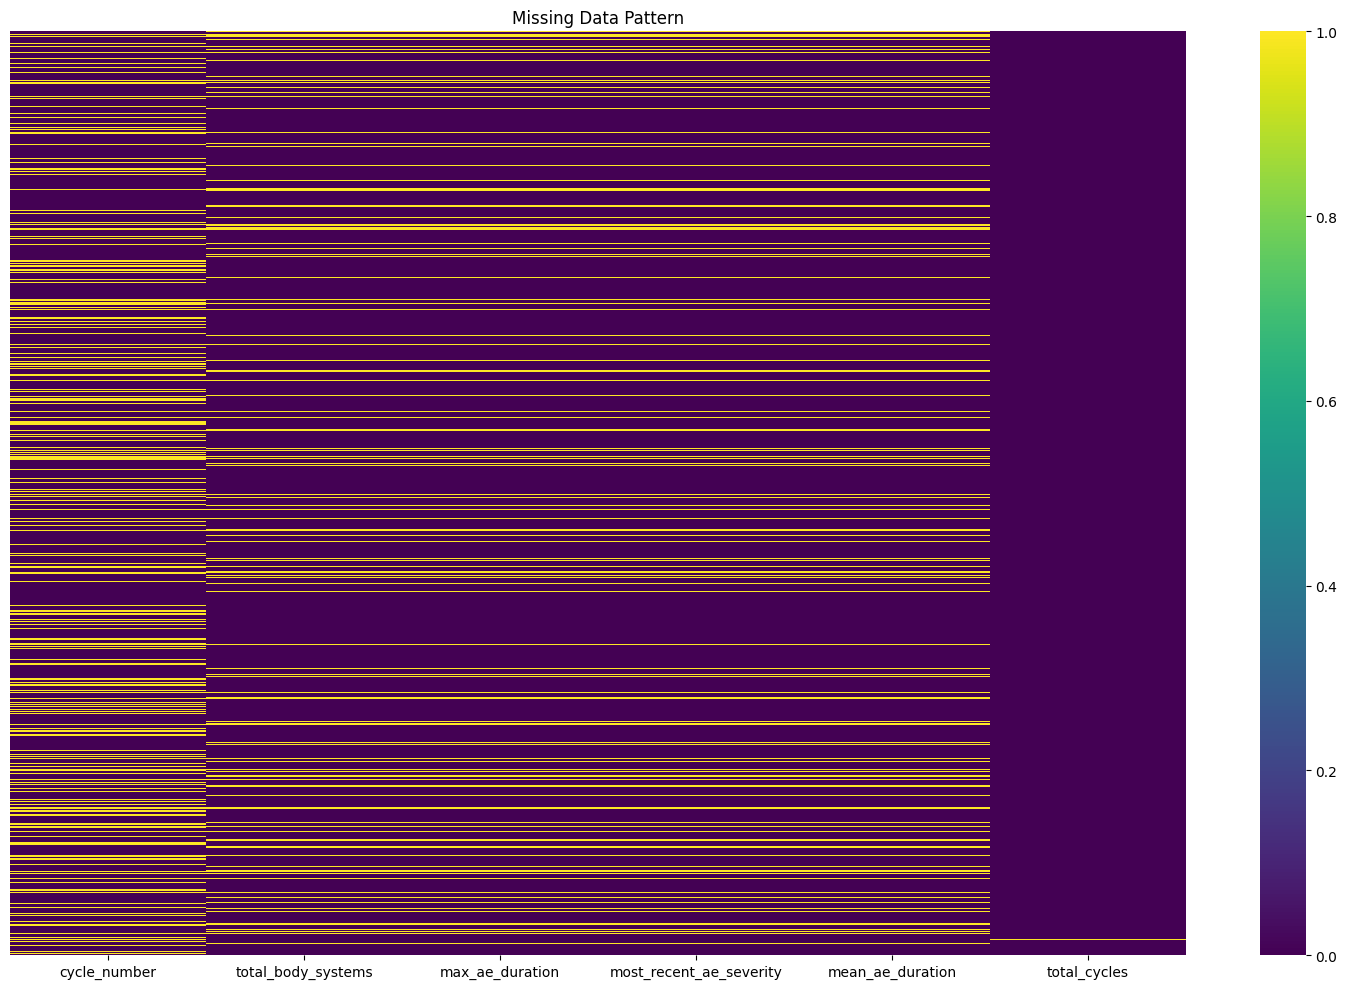

Numeric columns: 11
Categorical columns: 23

Preparing 34 features for autoencoder imputation:
- Numeric features: 11
- Categorical features: 23
Final feature matrix shape: (8056, 68)
Missing mask shape: (8056, 68)

Data split:
  Training: (4511, 68)
  Validation: (1128, 68)
  Test: (2417, 68)

Training Denoising Autoencoder for imputation...
Denoising Autoencoder architecture:


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_9                │ (None, 68)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 128)            │         8,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 68)             │         8,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,908 (155.89 KB)

 Trainable params: 39,140 (152.89 KB)

 Non-trainable params: 768 (3.00 KB)

None
Training denoising autoencoder with missing-aware loss...
Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5110 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4353 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2144 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1705 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1539 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1416 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1323 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1227 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━

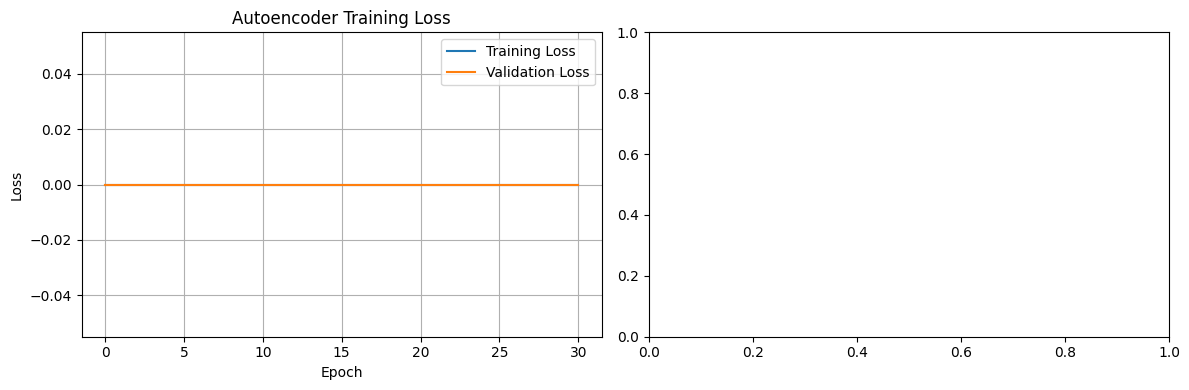


Imputing missing values...
Imputing missing values using trained autoencoder...
Imputed 3382.0 missing values
Imputing missing values using trained autoencoder...
Imputed 857.0 missing values
Imputing missing values using trained autoencoder...
Imputed 1815.0 missing values

STAGE 2: LSTM Survival Prediction

Sequence shapes:
  Training sequences: (1503, 3, 68), labels: (1503, 2)
  Validation sequences: (376, 3, 68), labels: (376, 2)
  Test sequences: (805, 3, 68), labels: (805, 2)

Training LSTM Autoencoder for feature extraction...
LSTM Autoencoder architecture:


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 3, 68)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 3, 64)          │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 3, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 3, 68)          │         4,420 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,036 (328.27 KB)

 Trainable params: 84,036 (328.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Training LSTM autoencoder...
Epoch 1/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 2.3878 - mae: 0.4646 - val_loss: 1.7387 - val_mae: 0.4260 - learning_rate: 0.0010
Epoch 2/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6011 - mae: 0.4136 - val_loss: 1.4597 - val_mae: 0.3951 - learning_rate: 0.0010
Epoch 3/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4225 - mae: 0.3939 - val_loss: 1.4064 - val_mae: 0.3904 - learning_rate: 0.0010
Epoch 4/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3755 - mae: 0.3883 - val_loss: 1.3686 - val_mae: 0.3843 - learning_rate: 0.0010
Epoch 5/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3403 - mae: 0.3839 - val_loss: 1.3329 - val_mae: 0.3810 - learning_rate: 0.0010
Epoch 6/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2929 - mae: 0.3801 - val_loss: 1.2536 - val_mae: 0.3733 - learning_rate: 0.0010
Epoch 7/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2195 - mae: 0.3715 - val_loss: 1.1951 - val_mae: 0.3681 - l

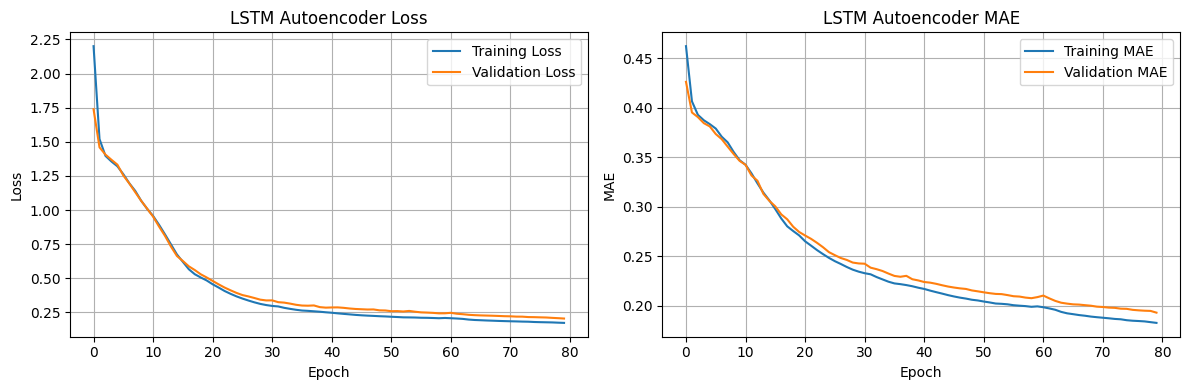


Extracting encoded features...

Training Survival LSTM...
Survival LSTM architecture:


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1, 32)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 1, 128)    │     49,664 │ input_layer_24[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 1, 128)    │          0 │ bidirectional_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 1, 1)      │        129 │ dropout_18[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_9 (Softmax) │ (None, 1, 1)      │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 128)    │          0 │ dropout_18[0][0], │
│ (Multiply)          │                   │            │ softmax_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 128)       │          0 │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 64)        │      8,256 │ lambda_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_93[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 32)        │      2,080 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_94[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ survival_time       │ (None, 1)         │         33 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ event (Dense)       │ (None, 1)         │         33 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,579 (236.64 KB)

 Trainable params: 60,387 (235.89 KB)

 Non-trainable params: 192 (768.00 B)

None
Training Survival LSTM...
Epoch 1/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - event_accuracy: 0.4922 - event_auc_9: 0.5121 - event_loss: 0.8793 - loss: 18669.8672 - survival_time_loss: 31116.4395 - survival_time_mae: 132.9869 - survival_time_root_mean_squared_error: 176.2114 - val_event_accuracy: 0.1995 - val_event_auc_9: 0.5004 - val_event_loss: 0.7516 - val_loss: 19963.9375 - val_survival_time_loss: 33617.3438 - val_survival_time_mae: 133.7924 - val_survival_time_root_mean_squared_error: 182.4081 - learning_rate: 5.0000e-04
Epoch 2/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - event_accuracy: 0.4460 - event_auc_9: 0.4776 - event_loss: 0.8913 - loss: 18396.7832 - survival_time_loss: 30661.2871 - survival_time_mae: 131.5999 - survival_time_root_mean_squared_error: 174.9159 - val_event_accuracy: 0.2979 - val_event_auc_9: 0.4891 - val_event_loss: 0.7447 - val_loss: 19815.7012 - val_survival_time_loss: 33371.4414 - val_survival_time_mae: 133.0287 - val_survival_time_root_mean_square

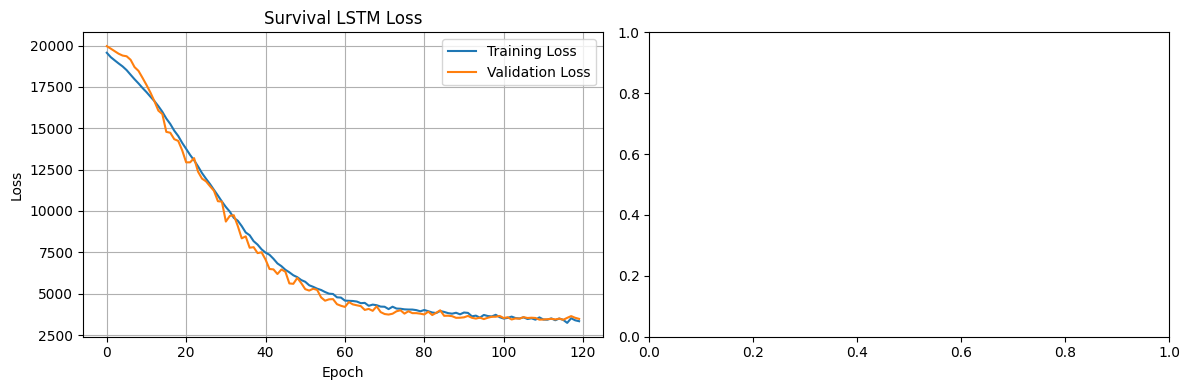


MODEL EVALUATION
Evaluating model...

Evaluation Results:
loss: 3653.3398
compile_metrics: 6203.8091
survival_time_loss: 0.4132
event_loss: 0.8646

Detailed Performance Metrics:

Survival Time Prediction:
  MSE: 6088.6300
  MAE: 53.9162
  RMSE: 78.0297

Event Prediction:
  Accuracy: 0.8646
  AUC-ROC: 0.5434


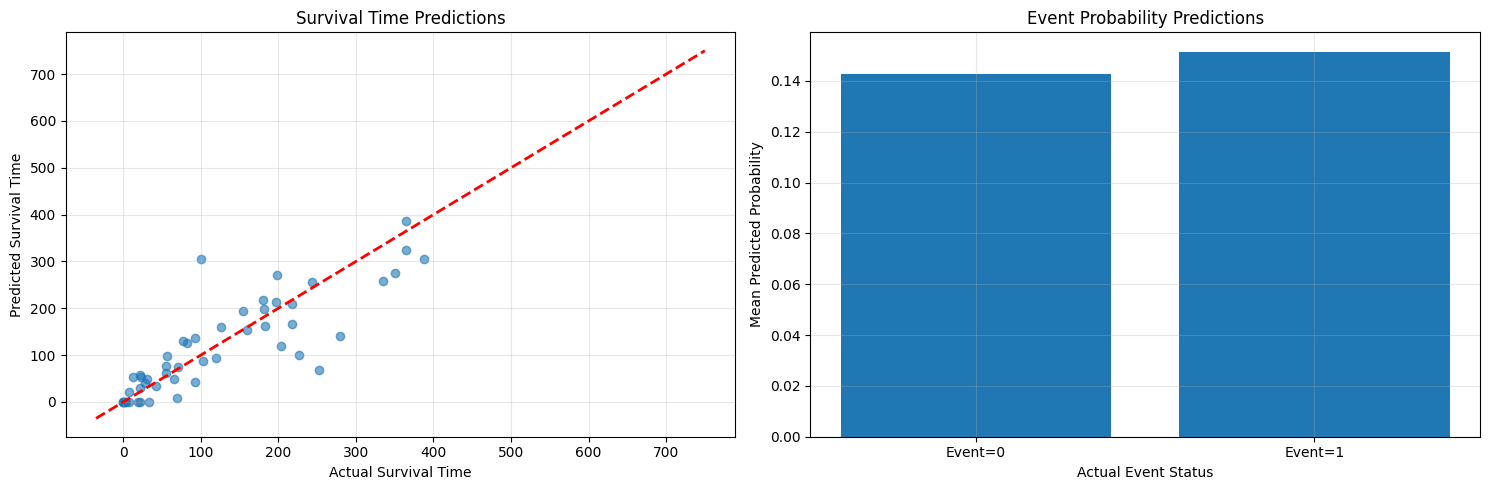


ADDITIONAL PLOTS


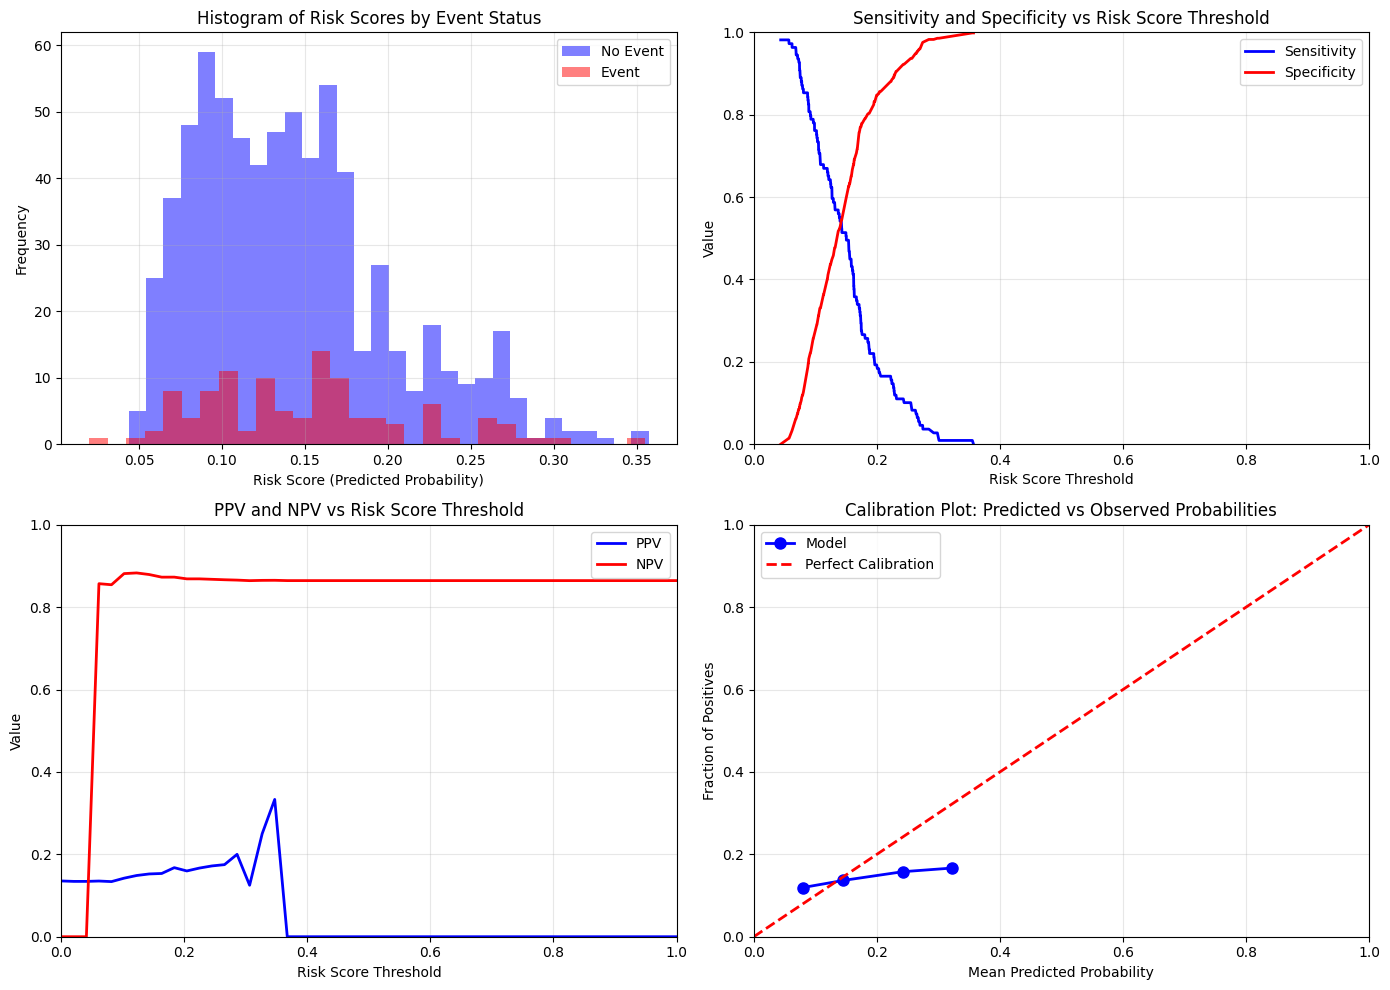

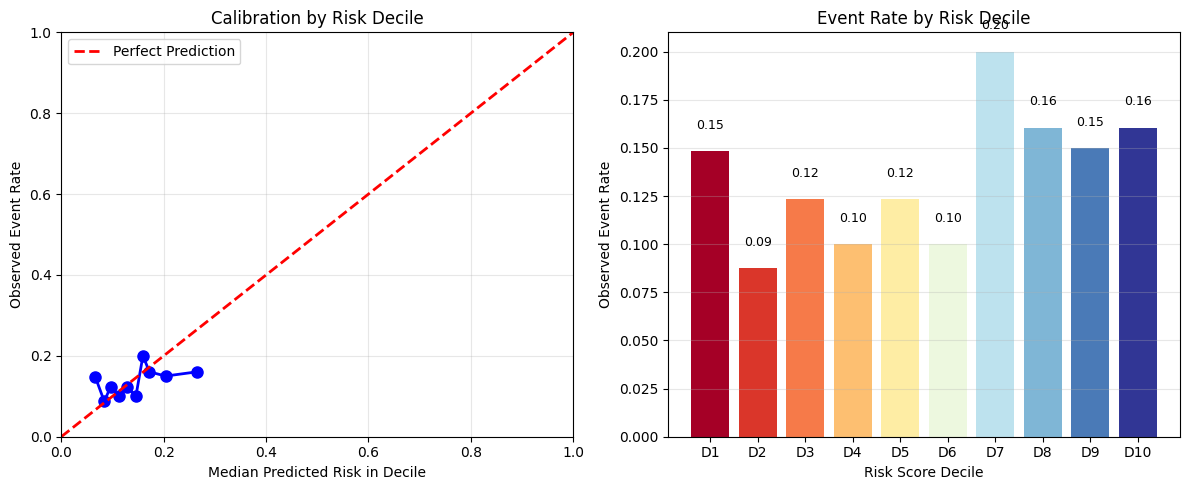

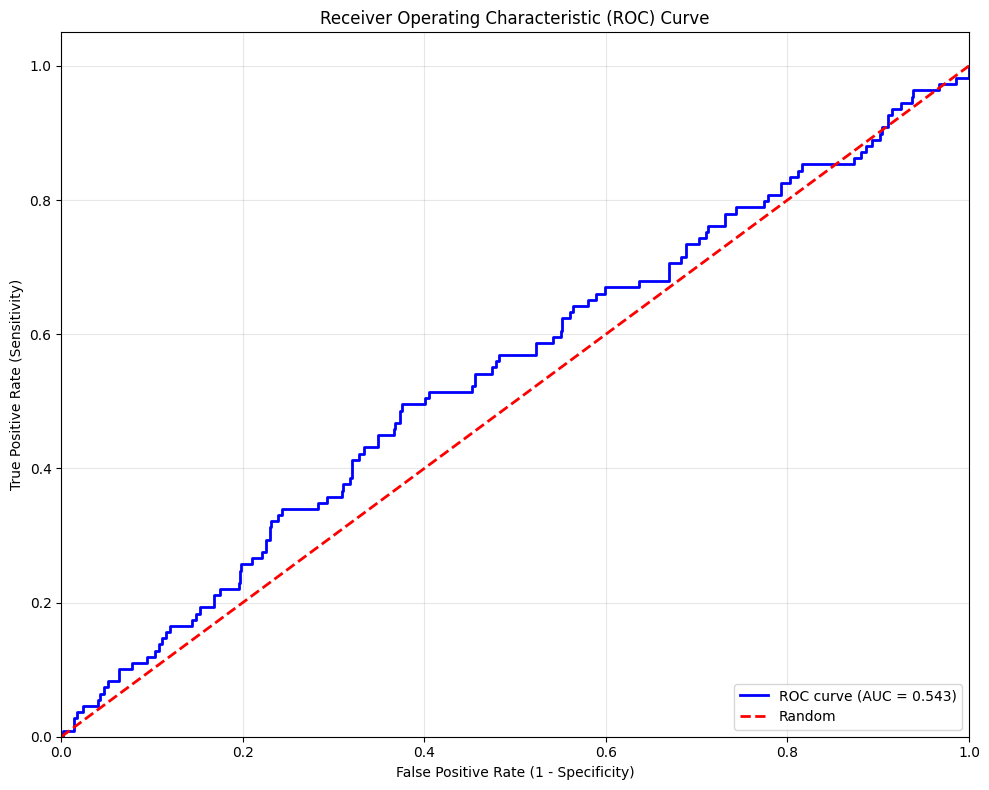


PIPELINE COMPLETED SUCCESSFULLY!


In [7]:
# ... (all the previous code remains the same until the train_complete_pipeline function) ...

def train_complete_pipeline():
    """Complete training pipeline with autoencoder imputation"""
    print("Starting Autoencoder Imputation + LSTM Survival Prediction Pipeline")
    print("=" * 70)

    try:
        # Load data
        print("Loading data...")
        pcdata = pd.read_csv('pcdata.csv')

        # Initialize preprocessor
        preprocessor = SurvivalDataPreprocessor()

        # Preprocess with autoencoder imputation
        print("\n" + "=" * 70)
        print("STAGE 1: Autoencoder-based Imputation")
        print("=" * 70)

        X_prepared, missing_mask, survival_data, all_columns, features = \
            preprocessor.preprocess_for_autoencoder_imputation(pcdata)

        # Split data
        X_train, X_test, mask_train, mask_test, y_train, y_test = train_test_split(
            X_prepared, missing_mask, survival_data,
            test_size=0.3, random_state=42
        )

        X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(
            X_train, mask_train, y_train,
            test_size=0.2, random_state=42
        )

        print(f"\nData split:")
        print(f"  Training: {X_train.shape}")
        print(f"  Validation: {X_val.shape}")
        print(f"  Test: {X_test.shape}")

        # Initialize and train denoising autoencoder for imputation
        print("\nTraining Denoising Autoencoder for imputation...")
        autoencoder_imputer = DenoisingAutoencoderImputer(
            input_dim=X_train.shape[1],
            encoding_dim=32,
            noise_factor=0.1
        )

        autoencoder_imputer.build_autoencoder()

        # Explicitly cast data to tf.float32 to prevent dtype mismatch errors
        X_train_tf = tf.cast(X_train, tf.float32)
        mask_train_tf = tf.cast(mask_train, tf.float32)
        X_val_tf = tf.cast(X_val, tf.float32)
        mask_val_tf = tf.cast(mask_val, tf.float32)

        autoencoder_imputer.train_with_missing_awareness(
            X_train_tf, mask_train_tf,
            X_val_tf, mask_val_tf,
            epochs=100,
            batch_size=64
        )

        # Impute missing values
        print("\nImputing missing values...")
        X_train_imputed = autoencoder_imputer.impute_missing_values(X_train_tf, mask_train_tf)
        X_val_imputed = autoencoder_imputer.impute_missing_values(X_val_tf, mask_val_tf)
        X_test_imputed = autoencoder_imputer.impute_missing_values(tf.cast(X_test, tf.float32), tf.cast(mask_test, tf.float32))

        preprocessor.autoencoder_imputer = autoencoder_imputer

        print("\n" + "=" * 70)
        print("STAGE 2: LSTM Survival Prediction")
        print("=" * 70)

        # Create sequences for LSTM
        sequence_length = 3

        # For simplicity, create synthetic sequences from the data
        def create_synthetic_sequences(X, y, seq_length):
            n_sequences = len(X) // seq_length
            X_seq = X[:n_sequences * seq_length].reshape(n_sequences, seq_length, -1)
            y_seq = y[:n_sequences * seq_length].reshape(n_sequences, seq_length, -1)
            # Use last time point for prediction
            y_seq = y_seq[:, -1, :]
            return X_seq, y_seq

        X_train_seq, y_train_seq = create_synthetic_sequences(X_train_imputed, y_train, sequence_length)
        X_val_seq, y_val_seq = create_synthetic_sequences(X_val_imputed, y_val, sequence_length)
        X_test_seq, y_test_seq = create_synthetic_sequences(X_test_imputed, y_test, sequence_length)

        print(f"\nSequence shapes:")
        print(f"  Training sequences: {X_train_seq.shape}, labels: {y_train_seq.shape}")
        print(f"  Validation sequences: {X_val_seq.shape}, labels: {y_val_seq.shape}")
        print(f"  Test sequences: {X_test_seq.shape}, labels: {y_test_seq.shape}")

        # Initialize and train LSTM autoencoder for feature extraction
        print("\nTraining LSTM Autoencoder for feature extraction...")
        lstm_ae = AutoencoderLSTM_Survival(
            input_dim=X_train_seq.shape[2],
            encoding_dim=32,
            sequence_length=sequence_length,
            lstm_units=64
        )

        lstm_ae.build_lstm_autoencoder()
        lstm_ae.train_lstm_autoencoder(
            X_train_seq, X_val_seq,
            epochs=80,
            batch_size=32
        )

        # Extract encoded features
        print("\nExtracting encoded features...")
        X_train_encoded = lstm_ae.encoder.predict(X_train_seq, verbose=0)
        X_val_encoded = lstm_ae.encoder.predict(X_val_seq, verbose=0)
        X_test_encoded = lstm_ae.encoder.predict(X_test_seq, verbose=0)

        # Reshape for survival LSTM
        X_train_encoded_seq = X_train_encoded.reshape(-1, 1, X_train_encoded.shape[1])
        X_val_encoded_seq = X_val_encoded.reshape(-1, 1, X_val_encoded.shape[1])
        X_test_encoded_seq = X_test_encoded.reshape(-1, 1, X_test_encoded.shape[1])

        # Initialize and train Survival LSTM
        print("\nTraining Survival LSTM...")
        lstm_survival_model = AutoencoderLSTM_Survival(
            input_dim=lstm_ae.encoding_dim,
            encoding_dim=lstm_ae.encoding_dim,
            sequence_length=1,
            lstm_units=lstm_ae.lstm_units
        )
        lstm_survival_model.build_survival_lstm()
        lstm_survival_model.train_survival_lstm(
            X_train_encoded_seq, y_train_seq,
            X_val_encoded_seq, y_val_seq,
            epochs=120,
            batch_size=32
        )

        # Evaluate
        print("\n" + "=" * 70)
        print("MODEL EVALUATION")
        print("=" * 70)

        results = lstm_survival_model.evaluate(X_test_encoded_seq, y_test_seq)

        # Make predictions
        predictions = lstm_survival_model.predict(X_test_encoded_seq)

        # Calculate additional metrics
        from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score

        # Survival time metrics
        y_pred_time = predictions[0].flatten()
        y_true_time = y_test_seq[:, 0]

        mse_time = mean_squared_error(y_true_time, y_pred_time)
        mae_time = mean_absolute_error(y_true_time, y_pred_time)
        rmse_time = np.sqrt(mse_time)

        # Event prediction metrics
        y_pred_event = predictions[1].flatten()
        y_pred_event_binary = (y_pred_event > 0.5).astype(int)
        y_true_event = y_test_seq[:, 1]

        event_accuracy = accuracy_score(y_true_event, y_pred_event_binary)
        event_auc = roc_auc_score(y_true_event, y_pred_event)

        print("\nDetailed Performance Metrics:")
        print(f"\nSurvival Time Prediction:")
        print(f"  MSE: {mse_time:.4f}")
        print(f"  MAE: {mae_time:.4f}")
        print(f"  RMSE: {rmse_time:.4f}")

        print(f"\nEvent Prediction:")
        print(f"  Accuracy: {event_accuracy:.4f}")
        print(f"  AUC-ROC: {event_auc:.4f}")

        # Plot some predictions
        plt.figure(figsize=(15, 5))

        # Plot survival time predictions
        plt.subplot(1, 2, 1)
        plt.scatter(y_true_time[:50], y_pred_time[:50], alpha=0.6)
        plt.plot([y_true_time.min(), y_true_time.max()],
                [y_true_time.min(), y_true_time.max()], 'r--', lw=2)
        plt.xlabel('Actual Survival Time')
        plt.ylabel('Predicted Survival Time')
        plt.title('Survival Time Predictions')
        plt.grid(True, alpha=0.3)

        # Plot event predictions
        plt.subplot(1, 2, 2)
        plt.bar(['Event=0', 'Event=1'],
                [np.mean(y_pred_event[y_true_event == 0]),
                 np.mean(y_pred_event[y_true_event == 1])])
        plt.xlabel('Actual Event Status')
        plt.ylabel('Mean Predicted Probability')
        plt.title('Event Probability Predictions')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\n" + "=" * 70)
        print("ADDITIONAL PLOTS")
        print("=" * 70)

        # ========== ADDED PLOTS ==========

        # 1. Histogram of risk scores color-coded by event status
        plt.figure(figsize=(14, 10))

        # Create risk scores from predicted probabilities
        risk_scores = y_pred_event

        # Plot histogram
        plt.subplot(2, 2, 1)
        plt.hist(risk_scores[y_true_event == 0], bins=30, alpha=0.5, label='No Event', color='blue')
        plt.hist(risk_scores[y_true_event == 1], bins=30, alpha=0.5, label='Event', color='red')
        plt.xlabel('Risk Score (Predicted Probability)')
        plt.ylabel('Frequency')
        plt.title('Histogram of Risk Scores by Event Status')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. Sensitivity and Specificity plot
        from sklearn.metrics import roc_curve

        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true_event, risk_scores)

        # Calculate sensitivity (TPR) and specificity (1-FPR)
        specificity = 1 - fpr
        sensitivity = tpr

        # FIX: thresholds has one more element than sensitivity/specificity
        # Use thresholds[:-1] to match dimensions
        plt.subplot(2, 2, 2)
        plt.plot(thresholds[:-1], sensitivity[:-1], 'b-', label='Sensitivity', linewidth=2)
        plt.plot(thresholds[:-1], specificity[:-1], 'r-', label='Specificity', linewidth=2)
        plt.xlabel('Risk Score Threshold')
        plt.ylabel('Value')
        plt.title('Sensitivity and Specificity vs Risk Score Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim([0, 1])
        plt.ylim([0, 1])

        # 3. PPV and NPV plot
        from sklearn.metrics import precision_score, recall_score

        # Calculate PPV (Positive Predictive Value) and NPV (Negative Predictive Value) for different thresholds
        thresholds_ppv_npv = np.linspace(0, 1, 50)
        ppv_values = []
        npv_values = []

        for threshold in thresholds_ppv_npv:
            y_pred_binary = (risk_scores >= threshold).astype(int)

            # Calculate PPV (precision)
            if sum(y_pred_binary) > 0:
                ppv = precision_score(y_true_event, y_pred_binary, zero_division=0)
            else:
                ppv = 0

            # Calculate NPV
            # True negatives / (true negatives + false negatives)
            tn = sum((y_pred_binary == 0) & (y_true_event == 0))
            fn = sum((y_pred_binary == 0) & (y_true_event == 1))
            if (tn + fn) > 0:
                npv = tn / (tn + fn)
            else:
                npv = 0

            ppv_values.append(ppv)
            npv_values.append(npv)

        plt.subplot(2, 2, 3)
        plt.plot(thresholds_ppv_npv, ppv_values, 'b-', label='PPV', linewidth=2)
        plt.plot(thresholds_ppv_npv, npv_values, 'r-', label='NPV', linewidth=2)
        plt.xlabel('Risk Score Threshold')
        plt.ylabel('Value')
        plt.title('PPV and NPV vs Risk Score Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim([0, 1])
        plt.ylim([0, 1])

        # 4. Predicted vs Observed probabilities (calibration plot)
        from sklearn.calibration import calibration_curve

        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_true_event, risk_scores, n_bins=10, strategy='uniform')

        plt.subplot(2, 2, 4)
        plt.plot(prob_pred, prob_true, 'bo-', linewidth=2, markersize=8, label='Model')
        plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Plot: Predicted vs Observed Probabilities')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim([0, 1])
        plt.ylim([0, 1])

        plt.tight_layout()
        plt.show()

        # 5. Additional detailed plot: Risk score distribution by decile
        plt.figure(figsize=(12, 5))

        # Create deciles of risk scores
        risk_score_deciles = pd.qcut(risk_scores, q=10, labels=False, duplicates='drop')

        # Calculate event rates in each decile
        event_rates_by_decile = []
        decile_centers = []

        for decile in range(min(10, len(np.unique(risk_score_deciles)))):
            decile_indices = risk_score_deciles == decile
            if sum(decile_indices) > 0:
                event_rate = np.mean(y_true_event[decile_indices])
                event_rates_by_decile.append(event_rate)
                # Use median risk score in decile as center
                decile_center = np.median(risk_scores[decile_indices])
                decile_centers.append(decile_center)

        plt.subplot(1, 2, 1)
        plt.plot(decile_centers, event_rates_by_decile, 'bo-', linewidth=2, markersize=8)
        plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
        plt.xlabel('Median Predicted Risk in Decile')
        plt.ylabel('Observed Event Rate')
        plt.title('Calibration by Risk Decile')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim([0, 1])
        plt.ylim([0, 1])

        # Bar plot of event rates by decile
        plt.subplot(1, 2, 2)
        n_deciles = len(event_rates_by_decile)
        decile_labels = [f'D{i+1}' for i in range(n_deciles)]
        colors = plt.cm.RdYlBu(np.linspace(0, 1, n_deciles))
        bars = plt.bar(decile_labels, event_rates_by_decile, color=colors)
        plt.xlabel('Risk Score Decile')
        plt.ylabel('Observed Event Rate')
        plt.title('Event Rate by Risk Decile')
        plt.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, rate in zip(bars, event_rates_by_decile):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{rate:.2f}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

        # 6. Additional: Show ROC curve with AUC
        plt.figure(figsize=(10, 8))

        # Calculate AUC
        from sklearn.metrics import auc
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, 'b-', label=f'ROC curve (AUC = {roc_auc:.3f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'r--', label='Random', linewidth=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return lstm_survival_model, preprocessor, results, predictions, y_test_seq
    except FileNotFoundError:
        print("Error: 'pcdata.csv' not found.")
        return None, None, None, None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None


# Run the pipeline
if __name__ == "__main__":
    model, preprocessor, results, predictions, y_test_seq = train_complete_pipeline()

    if model is not None:
        print("\n" + "=" * 70)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 70)